# Data Visualiztion/EDA

This notebook does some basic visualization to make sure the data is being handled correctly, and to inspect the performance of a trained model. In general the model is performing pretty decently with what is a currently an unoptimized and unfinished implementation. 

Improvements which could be made include:
- Longer training time to actually reach the minimum of the validation loss training curve. (Trained models imported below were saved before they reached that point.)
- More expansive augmentation strategy including affine and other geometrically warping transforms.
- Better base model architecture beyond simple Keras U-Net implementation.
- Actual hyperparameter and data-parameter optimization to find better parameters. (This was only explored to the point of getting a well-behaved model.)
- More expansive cross-validation training strategy using the other available splits/datasets in the data.
Implementing these steps would go a very long way towards improving model performance.


In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import tf_data_utils
import keras_cv
import tensorflow as tf

2023-09-15 10:51:23.462005: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


/Users/NickPC/Documents/DataScience/PersonalProjects/SurgicalSegmentation/env-ss/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset Path

Currently we're working with the real images subset of the larger dataset, and the first train/validation split of the data. In the future this can be expanded to the synthetic images or other train/validation sets as desired. Similarly we're testing/training with the semantic segmentation labels, as opposed to the instance segmentation labels. This can also be included in the future.

In [3]:
dataset_dir = '/Users/NickPC/Documents/DataScience/Datasets/miccai2022_sisvse_dataset/'
real_images_dir = dataset_dir + "images/real/"
real_masks_train_dir = dataset_dir + 'semantic_masks/real_train_1/'

Verify that the image names and label names are aligned.

In [4]:
image_index = 32
first_image = sorted(os.listdir(real_images_dir))[image_index]
first_img = Image.open(real_images_dir + first_image)
print(first_image)
first_mask = sorted(os.listdir(real_masks_train_dir))[image_index]
first_msk = Image.open(real_masks_train_dir + first_mask)
print(first_mask)

R001_ch1_video_01_00-57-14-23.jpg
R001_ch1_video_01_00-57-14-23.png


## Inspect Data

Visualize an image and mask to see what things look like.

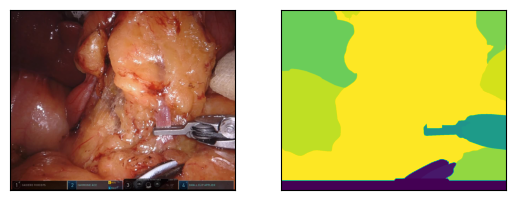

In [5]:
f, axs = plt.subplots(1,2)
axs[0].imshow(first_img)
axs[1].imshow(first_msk)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()


Image and mask is aligned which is good to see. 

The real images for some reason contain some kind of overlay in the images. These overlay pixels correspond to class 0 in the labeling scheme, which is not listed in the data readme file. This overlay should be dealt with in the future, though it's a bit tricky since it's a not-insignificant portion of the image, the overlay is partially transparent, etc.

Double check that the mask values make sense.

In [6]:
np.unique(np.asarray(first_msk), return_counts=True)

(array([ 0,  1,  2, 16, 17, 24, 25, 26, 28, 29, 31], dtype=uint8),
 array([ 82403,   9904,   9455,  13108,  41273, 142051,  35002,  49977,
        138725,  33536, 755286]))

## Load Segmentation Dataset

Load the dataset identically to how `train.py` uses it, via the `tf_data_utils.py` class. Batch size is set to 4 here in order to facilitate some plotting code. The train dataset will have augmentations applied while the validation dataset will not.

In [7]:
images_dir = '/Users/NickPC/Documents/DataScience/Datasets/miccai2022_sisvse_dataset/images/real/'
train_masks_dir = '/Users/NickPC/Documents/DataScience/Datasets/miccai2022_sisvse_dataset/semantic_masks/real_train_1/'
val_masks_dir = '/Users/NickPC/Documents/DataScience/Datasets/miccai2022_sisvse_dataset/semantic_masks/real_val_1/'

train_dataset = tf_data_utils.SegmentationDataset(images_dir=images_dir, masks_dir=train_masks_dir, augment=True, batch_size=4, shuffle=False).get_dataset()
val_dataset = tf_data_utils.SegmentationDataset(images_dir=images_dir, masks_dir=val_masks_dir, augment=False, batch_size=4, shuffle=False).get_dataset()

Double check dataset is performing appropriately.

In [8]:
for element in train_dataset.take(1):
    print(np.unique(np.asarray(element[1]), return_counts=True))
    print(np.asarray(element[1]).shape)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 24, 25, 28, 30, 31],
      dtype=uint8), array([133172,   9618,   2731,   5416,   3904,   5362,   1162,    113,
         2443,   4907,   8432, 135345,  47885,  14573,  55199, 618314]))
(4, 512, 512, 1)


2023-09-15 10:51:50.280934: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Load Trained Model

In [9]:
# trained_model = tf.keras.models.load_model('models/test_segmentation_model-v1.keras')
# trained_model = tf.keras.models.load_model('models/test_segmentation_model-v2.keras')
trained_model = tf.keras.models.load_model('models/test_segmentation_model-v3.keras')

## Visualize Predictions

Visualize images along with their true and predicted masks. Train elements are shown first, which allows us to view how the augmentations are applied.

2023-09-15 10:51:56.509452: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 [==============================] - 6s 6s/step


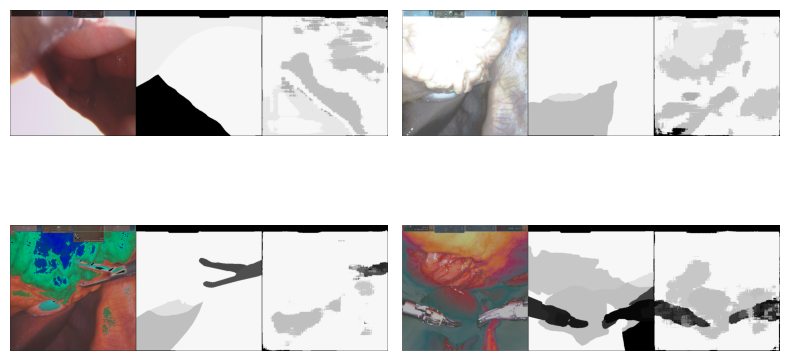

In [10]:
viz_images, viz_masks = next(iter(train_dataset.take(1)))

# print(viz_images.shape)
# print(viz_masks.shape)

if trained_model is not None:
    pred_masks = trained_model.predict(viz_images)
    pred_masks = tf.math.argmax(pred_masks, axis=-1)
    pred_masks = pred_masks[..., tf.newaxis]
    # print(pred_masks.shape)
else:
    pred_masks = None

keras_cv.visualization.plot_segmentation_mask_gallery(
    viz_images,
    value_range=(0, 1),
    num_classes=32,
    y_true=viz_masks,
    y_pred=pred_masks,
    scale=4,
    rows=2,
    cols=2,
)

Train images are shown correctly and augmentations are applied nicely. Predicted masks on the far right are okay in some cases and need some more work in others. Since the trained model is not fully optimized this level of performance with the simple implementation is pretty good to see.

2023-09-15 10:52:10.154303: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 [==============================] - 3s 3s/step


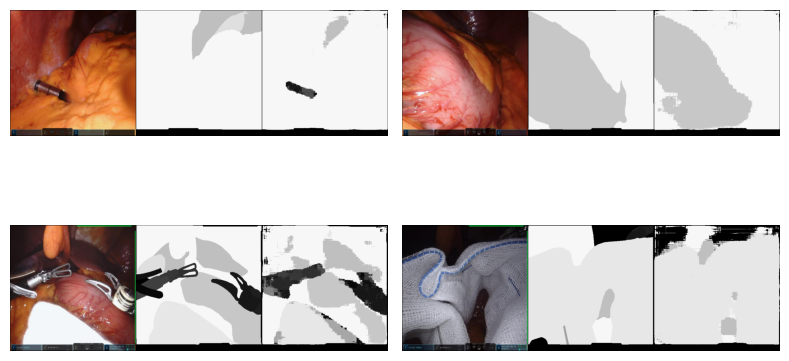

In [11]:
viz_images, viz_masks = next(iter(val_dataset.take(1)))

# print(viz_images.shape)
# print(viz_masks.shape)

if trained_model is not None:
    pred_masks = trained_model.predict(viz_images)
    pred_masks = tf.math.argmax(pred_masks, axis=-1)
    pred_masks = pred_masks[..., tf.newaxis]
    # print(pred_masks.shape)
else:
    pred_masks = None

keras_cv.visualization.plot_segmentation_mask_gallery(
    viz_images,
    value_range=(0, 1),
    num_classes=32,
    y_true=viz_masks,
    y_pred=pred_masks,
    scale=4,
    rows=2,
    cols=2,
)

Validation images along with their true and predicted masks are shown here. The predictions are even better for these images than the train images, which is unsurprising since no augmentations are applied and the model performs better. Again the model needs work but it's good to see this level of performance with the current level of implementation.